# Get elevation data given lat and lon 

## We will use elevation data from https://www.landfire.gov/version_download.php# 

In [1]:
import geopandas as gpd
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt

In [7]:
#File paths
data_path          = '/Users/hrh/Desktop/AI/erdos/rapower_data/'
# data_path2     = '/Users/hrh/Desktop/AI/erdos/SolarFarmPrediction/data/'
data_path2         = '/Users/hrh/Desktop/AI/erdos/SolarFarmPrediction/new_data/threshold_95percentile/'
ca_gridpath        = data_path2 + 'ca_data_version_1.csv'
elevation_datapath = data_path + 'LF2020_Elev_220_CONUS/'

### Read lats and lons for CA into a GeoDataframe

In [9]:
# df_main             = pd.read_csv(ca_gridpath)
# ca_grid             = df_main.loc[df_main['State']=='CA']
ca_grid              = pd.read_csv(ca_gridpath)
# ca_grid_usable      = ca_grid.loc[ca_grid['land_cover']==1.0]
ca_coords           = list(zip(ca_grid['Latitude'], ca_grid['Longitude']))
#Check if ca_coords are within california grid box
ca_lats = [item[0] for item in ca_coords] 
ca_lons = [item[1] for item in ca_coords]
(min(ca_lats),max(ca_lats)),(min(ca_lons),max(ca_lons))

((32.53767702167681, 42.00186839932766),
 (-124.47184652921426, -114.13859171386824))

In [4]:
# Create a GeoDataFrame for California coordinates
geometry = [Point(xy) for xy in ca_coords]
# ca_gdf   = gpd.GeoDataFrame(geometry=geometry)
ca_gdf   = gpd.GeoDataFrame({'geometry': [Point(lon, lat) for lat, lon in ca_coords]
                           }, crs="EPSG:4326")  # Make sure to set the correct coordinate reference system
ca_gdf

,geometry
0,POINT (-120.10900 36.17760)
1,POINT (-116.32800 33.26520)
2,POINT (-118.34800 34.82300)
3,POINT (-118.30500 34.70740)
4,POINT (-118.27400 34.70860)
...,...
101697,POINT (-114.16016 34.27799)
101698,POINT (-114.16016 34.29755)
101699,POINT (-114.16016 34.31710)
101700,POINT (-114.13859 34.25844)


### Read elevation data 

In [5]:
#elevation data path 
elevation_tif_path = elevation_datapath + 'Tif/LC20_Elev_220.tif'
# Open the elevation raster
# Check the CRS of the GeoDataFrame and the Raster
with rasterio.open(elevation_tif_path) as src:
    print(f"Raster CRS: {src.crs}")
    print(f"Raster Bounds: {src.bounds}")

print(f"GeoDataFrame CRS: {ca_gdf.crs}")

Raster CRS: EPSG:5070
Raster Bounds: BoundingBox(left=-2362395.0, bottom=221265.0, right=2327655.0, top=3267405.0)
GeoDataFrame CRS: EPSG:4326


In [6]:
with rasterio.open(elevation_tif_path) as src:
    #Convert the ca_gdf dataframe to the crs of the source
    ca_gdf = ca_gdf.to_crs(src.crs)
    # Mask the raster with the GeoDataFrame to get the elevation values for California coordinates
    # out_image, out_transform = mask(src, [g for g in ca_gdf['geometry'].values], crop=True)
    # ca_elevation_data            = out_image[0]  # Assuming elevation data is in the first band
    # Sample the raster at the given points
    ca_elevation_values = [val[0] for val in src.sample([(geom.x, geom.y) for geom in ca_gdf.geometry])]


In [7]:
len(ca_elevation_values)

101702

In [8]:
# Create a DataFrame from the sampled elevation values
ca_elevation = pd.DataFrame({
    'lat': [geom.y for geom in ca_gdf.geometry],
    'lon': [geom.x for geom in ca_gdf.geometry],
    'elevation': ca_elevation_values
})

In [9]:
ca_elevation

,lat,lon,elevation
0,1.729738e+06,-2.125860e+06,119
1,1.333362e+06,-1.867195e+06,164
2,1.544300e+06,-2.008899e+06,768
3,1.530815e+06,-2.008112e+06,748
4,1.530291e+06,-2.005341e+06,731
...,...,...,...
101697,1.404102e+06,-1.649158e+06,201
101698,1.406249e+06,-1.648743e+06,228
101699,1.408395e+06,-1.648327e+06,148
101700,1.401582e+06,-1.647637e+06,112


###  Convert the DataFrame back to a GeoDataFrame with the original CRS (EPSG:4326)

In [10]:
#CRS transformation after creating a geodata frame
ca_elevation_gdf = gpd.GeoDataFrame(ca_elevation, geometry=gpd.points_from_xy(ca_elevation.lon, ca_elevation.lat),crs='EPSG:5070') # Set to raster's CRS to match the sampling
print('The coordinate reference system of ca_elevation_gdf is:',ca_elevation_gdf.crs)

# Now, reproject to EPSG:4326
ca_elevation_gdf = ca_elevation_gdf.to_crs("EPSG:4326")
print('The coordinate reference system of ca_elevation_gdf is:',ca_elevation_gdf.crs)

# Assuming 'ca_elevation_gdf' has been correctly reprojected to EPSG:4326
ca_elevation_gdf['lat'] = ca_elevation_gdf.geometry.y
ca_elevation_gdf['lon'] = ca_elevation_gdf.geometry.x

The coordinate reference system of ca_elevation_gdf is: EPSG:5070
The coordinate reference system of ca_elevation_gdf is: EPSG:4326


In [11]:
#### Because of re-gridding, some points have no slope data and I have decided to set those slopes to None
no_data_locations = ca_elevation_gdf[ca_elevation_gdf['elevation'] == -9999]
no_data_locations

,lat,lon,elevation,geometry
2360,39.401171,-123.889387,-9999,POINT (-123.88939 39.40117)
2608,39.205630,-123.846242,-9999,POINT (-123.84624 39.20563)
3205,39.029643,-123.759952,-9999,POINT (-123.75995 39.02964)
5515,38.619007,-123.457936,-9999,POINT (-123.45794 38.61901)
13441,37.797734,-122.595034,-9999,POINT (-122.59503 37.79773)
13664,37.699963,-122.573462,-9999,POINT (-122.57346 37.69996)
13665,37.719517,-122.573462,-9999,POINT (-122.57346 37.71952)
13666,37.739071,-122.573462,-9999,POINT (-122.57346 37.73907)
16323,37.054677,-122.336163,-9999,POINT (-122.33616 37.05468)
20211,36.487611,-122.012575,-9999,POINT (-122.01258 36.48761)


In [12]:
# Verify the transformation
ca_elevation_gdf

,lat,lon,elevation,geometry
0,36.177601,-120.109001,119,POINT (-120.10900 36.17760)
1,33.265202,-116.328003,164,POINT (-116.32800 33.26520)
2,34.823005,-118.347998,768,POINT (-118.34800 34.82300)
3,34.707404,-118.304999,748,POINT (-118.30500 34.70740)
4,34.708602,-118.274000,731,POINT (-118.27400 34.70860)
...,...,...,...,...
101697,34.277993,-114.160164,201,POINT (-114.16016 34.27799)
101698,34.297547,-114.160164,228,POINT (-114.16016 34.29755)
101699,34.317101,-114.160164,148,POINT (-114.16016 34.31710)
101700,34.258439,-114.138592,112,POINT (-114.13859 34.25844)


In [13]:
ca_elevation_gdf.loc[ca_elevation_gdf['elevation'] == -9999, 'elevation'] = None

### Finally, load the CA shape file and check if the elevation information makes sense by plotting 

EPSG:4326


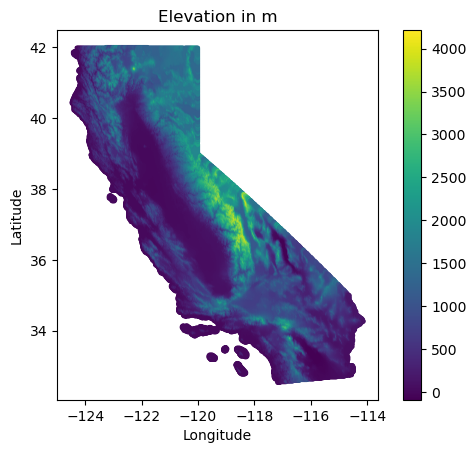

In [14]:
# Load the California shapefile
ca_shapfile_path = data_path+ 'ca_state_boundary/CA_State_TIGER2016.shp'
ca_shape         = gpd.read_file(ca_shapfile_path)
ca_shape         = ca_shape.to_crs("EPSG:4326")
print(ca_shape.crs)
# Plot the California shapefile as the base
ca_shape.plot(color='white', edgecolor='black')

# Plot the elevation data
ca_elevation_gdf.plot(ax=plt.gca(), column='elevation', legend=True, markersize=5, cmap='viridis')

plt.title('Elevation in m')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


## Finally, save the dataframe to a csv file after dropping the 'geometry' column

In [15]:
# Save to CSV
ca_elevation_gdf.drop(columns='geometry').to_csv(data_path2+'ca_elevation.csv', index=False)

In [16]:
#Check
ca_elevation_check = pd.read_csv(data_path2+'ca_elevation.csv')
ca_elevation_check

,lat,lon,elevation
0,36.177601,-120.109001,119.0
1,33.265202,-116.328003,164.0
2,34.823005,-118.347998,768.0
3,34.707404,-118.304999,748.0
4,34.708602,-118.274000,731.0
...,...,...,...
101697,34.277993,-114.160164,201.0
101698,34.297547,-114.160164,228.0
101699,34.317101,-114.160164,148.0
101700,34.258439,-114.138592,112.0


### Add elevation data to the big dataframe

In [18]:
ca_features = pd.read_csv(data_path2+'ca_data_version_1.csv')
# ca_features0    = conus_features0.loc[df_main['State']=='CA']
ca_features

,Latitude,Longitude,Solar_farm_present,land_cover,slope
0,36.177601,-120.109001,1,1.0,0.0
1,33.265202,-116.328003,1,1.0,1.0
2,34.823002,-118.348000,1,1.0,0.0
3,34.707401,-118.305000,1,1.0,0.0
4,34.708599,-118.274002,1,1.0,0.0
...,...,...,...,...,...
101697,34.277993,-114.160164,0,1.0,3.0
101698,34.297547,-114.160164,0,1.0,31.0
101699,34.317101,-114.160164,0,1.0,20.0
101700,34.258439,-114.138592,0,0.0,0.0


In [19]:
# Ensure both GeoDataFrames have the same CRS
# Convert ca_features to a GeoDataFrame
gdf_ca_features = gpd.GeoDataFrame(
    ca_features, 
    geometry=gpd.points_from_xy(ca_features.Longitude, ca_features.Latitude),
    crs="EPSG:4326"
)

# Ensure ca_elevation is a GeoDataFrame with the same CRS
gdf_ca_elevation = gpd.GeoDataFrame(
    ca_elevation_check,
    geometry=gpd.points_from_xy(ca_elevation_check.lon, ca_elevation_check.lat),
    crs="EPSG:4326"
)

# Reproject to a suitable projected CRS for accurate distance calculations
gdf_ca_features     = gdf_ca_features.to_crs("EPSG:3310")
gdf_ca_elevation    = gdf_ca_elevation.to_crs("EPSG:3310")


In [20]:
# Perform the spatial join to find the nearest neighbors and get their 'elevation'
ca_features_with_elevation = gpd.sjoin_nearest(gdf_ca_features, gdf_ca_elevation[['geometry', 'elevation']], how='left', distance_col='distance')

# If you don't need the distance information, drop the 'distance' column
ca_features_with_elevation.drop(columns=['index_right', 'distance',], inplace=True)

# Optionally, project back to geographic CRS if needed for other purposes
ca_features_with_elevation = ca_features_with_elevation.to_crs("EPSG:4326")

ca_features_with_elevation

,Latitude,Longitude,Solar_farm_present,land_cover,slope,geometry,elevation
0,36.177601,-120.109001,1,1.0,0.0,POINT (-120.10900 36.17760),119.0
1,33.265202,-116.328003,1,1.0,1.0,POINT (-116.32800 33.26520),164.0
2,34.823002,-118.348000,1,1.0,0.0,POINT (-118.34800 34.82300),768.0
3,34.707401,-118.305000,1,1.0,0.0,POINT (-118.30500 34.70740),748.0
4,34.708599,-118.274002,1,1.0,0.0,POINT (-118.27400 34.70860),731.0
...,...,...,...,...,...,...,...
101697,34.277993,-114.160164,0,1.0,3.0,POINT (-114.16016 34.27799),201.0
101698,34.297547,-114.160164,0,1.0,31.0,POINT (-114.16016 34.29755),228.0
101699,34.317101,-114.160164,0,1.0,20.0,POINT (-114.16016 34.31710),148.0
101700,34.258439,-114.138592,0,0.0,0.0,POINT (-114.13859 34.25844),112.0


In [22]:
ca_features_with_elevation.loc[ca_features_with_elevation['land_cover']==0.0]['elevation']

471         0.0
472         0.0
473         0.0
474         0.0
475         0.0
          ...  
101577    137.0
101626    137.0
101690    138.0
101696    138.0
101700    112.0
Name: elevation, Length: 27313, dtype: float64

In [23]:
solar_farms = ca_features_with_elevation[ca_features_with_elevation['Solar_farm_present'] == 1]
solar_farms

,Latitude,Longitude,Solar_farm_present,land_cover,slope,geometry,elevation
0,36.177601,-120.109001,1,1.0,0.0,POINT (-120.10900 36.17760),119.0
1,33.265202,-116.328003,1,1.0,1.0,POINT (-116.32800 33.26520),164.0
2,34.823002,-118.348000,1,1.0,0.0,POINT (-118.34800 34.82300),768.0
3,34.707401,-118.305000,1,1.0,0.0,POINT (-118.30500 34.70740),748.0
4,34.708599,-118.274002,1,1.0,0.0,POINT (-118.27400 34.70860),731.0
...,...,...,...,...,...,...,...
466,34.564400,-117.694000,1,1.0,1.0,POINT (-117.69400 34.56440),914.0
467,39.651600,-121.650002,1,1.0,3.0,POINT (-121.65000 39.65160),102.0
468,34.687302,-118.320000,1,1.0,1.0,POINT (-118.32000 34.68730),772.0
469,32.660400,-115.629997,1,1.0,0.0,POINT (-115.63000 32.66040),-3.0


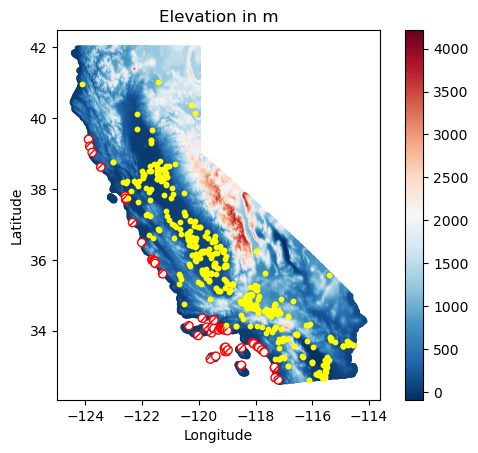

In [24]:
# Plot the California shapefile as the base only locations with solar farms

fig, ax = plt.subplots()
ca_shape.plot(ax=ax,color='white', edgecolor='black')

# Plot the slope data
ca_features_with_elevation.plot(ax=ax, column='elevation', legend=True, markersize=5, cmap='RdBu_r',  missing_kwds={
        "color": "white",
        #"edgecolor": "red",
        "hatch": "///",
        "label": "Missing values",
    })



# Plot these points on top of the existing plot
solar_farms.plot(ax=ax, color='yellow', markersize=10, marker='o', label='solar_farms')

#Title and axis labels
plt.title('Elevation in m')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
# Add a legend
# plt.legend()

# Show the plot
plt.show()

### Finally, save this data as a CSV file

In [25]:
ca_features_with_elevation.drop(columns='geometry').to_csv(data_path2+'ca_data_version_2.csv', index=False)

In [26]:
ca_features_with_elevation_check = pd.read_csv(data_path2+'ca_data_version_2.csv')
ca_features_with_elevation_check 

,Latitude,Longitude,Solar_farm_present,land_cover,slope,elevation
0,36.177601,-120.109001,1,1.0,0.0,119.0
1,33.265202,-116.328003,1,1.0,1.0,164.0
2,34.823002,-118.348000,1,1.0,0.0,768.0
3,34.707401,-118.305000,1,1.0,0.0,748.0
4,34.708599,-118.274002,1,1.0,0.0,731.0
...,...,...,...,...,...,...
101697,34.277993,-114.160164,0,1.0,3.0,201.0
101698,34.297547,-114.160164,0,1.0,31.0,228.0
101699,34.317101,-114.160164,0,1.0,20.0,148.0
101700,34.258439,-114.138592,0,0.0,0.0,112.0
